In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## Loading the  ETTh1 dataset

In [3]:
link = "ETTh1.csv"
df = pd.read_csv(link)
df['date'] = pd.to_datetime(df['date'])
df.drop("Id", axis=1, inplace=True)
df.head()

,date,OT
0,2016-07-01 00:00:00,30.531000
1,2016-07-01 01:00:00,27.787001
2,2016-07-01 02:00:00,27.787001
3,2016-07-01 03:00:00,25.044001
4,2016-07-01 04:00:00,21.948000


In [4]:
df.shape

(17320, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17320 entries, 0 to 17319
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    17320 non-null  datetime64[ns]
 1   OT      17320 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 270.8 KB


## Creating lags

= lags are the previous time stamps values that are used to forecast 

In [6]:
# Create lag features
lags = 365 #Number of lags to include
for i in range(1, lags + 1):
    df[f'OT_lag_{i}'] = df['OT'].shift(i).copy()


## Split data

In [7]:
# Split data into train and test sets
train_size = int(len(df) * 0.8) # 80% train, 20% test
train_data, test_data = df.iloc[:train_size].copy(), df.iloc[train_size:].copy()

In [8]:
train_data.shape, test_data.shape # number of rows * date + OT + lags 

((13856, 367), (3464, 367))

In [9]:
train_data.head(11)

,date,OT,OT_lag_1,OT_lag_2,OT_lag_3,OT_lag_4,OT_lag_5,OT_lag_6,OT_lag_7,OT_lag_8,...,OT_lag_356,OT_lag_357,OT_lag_358,OT_lag_359,OT_lag_360,OT_lag_361,OT_lag_362,OT_lag_363,OT_lag_364,OT_lag_365
0,2016-07-01 00:00:00,30.531000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-01 01:00:00,27.787001,30.531000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-01 02:00:00,27.787001,27.787001,30.531000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-01 03:00:00,25.044001,27.787001,27.787001,30.531000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-01 04:00:00,21.948000,25.044001,27.787001,27.787001,30.531000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016-07-01 05:00:00,21.174000,21.948000,25.044001,27.787001,27.787001,30.531000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2016-07-01 06:00:00,22.792000,21.174000,21.948000,25.044001,27.787001,27.787001,30.531000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2016-07-01 07:00:00,23.143999,22.792000,21.174000,21.948000,25.044001,27.787001,27.787001,30.531000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2016-07-01 08:00:00,21.667000,23.143999,22.792000,21.174000,21.948000,25.044001,27.787001,27.787001,30.531000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2016-07-01 09:00:00,17.445999,21.667000,23.143999,22.792000,21.174000,21.948000,25.044001,27.787001,27.787001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## XGBoost: train and test it on the remaining 20%

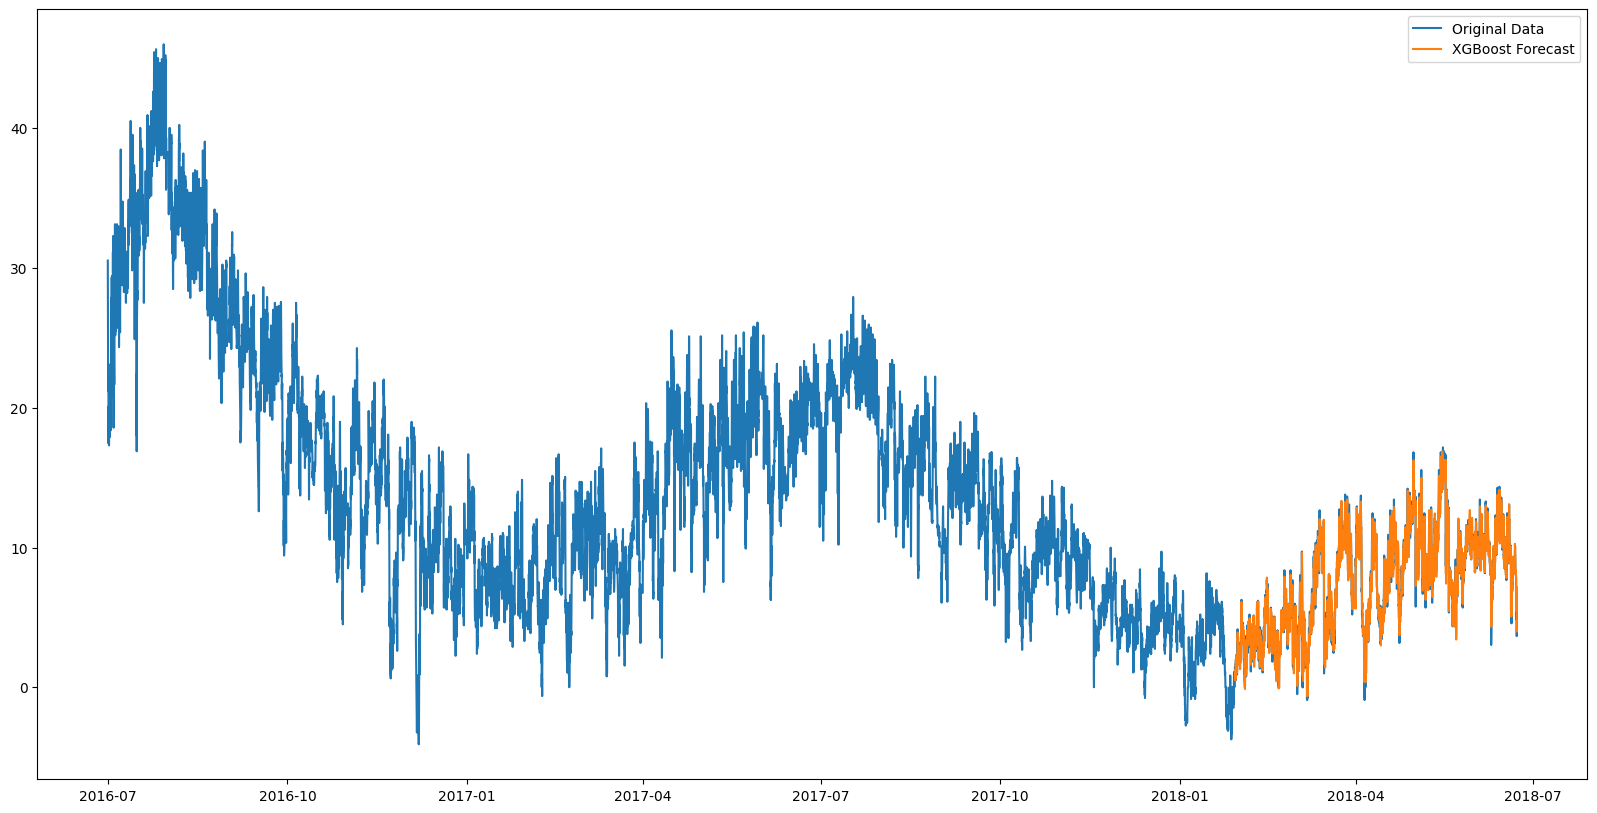

In [10]:
import xgboost as xgb

# Assuming df is your DataFrame with columns 'date' and 'OT'
# Define XGBoost model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Fit model
model_xgb.fit(train_data.drop(['date', 'OT'], axis=1), train_data['OT'])

# Forecast test values
forecast_test = model_xgb.predict(test_data.drop(['date', 'OT'], axis=1))

# Plot original data and forecast
plt.figure(figsize=(20, 10))
plt.plot(df['date'], df['OT'], label='Original Data')
plt.plot(test_data['date'], forecast_test, label='XGBoost Forecast')
plt.legend()
plt.show()

## Forecast next 100 hour 

In [15]:
# Generate lag features for the next 100 hour
future_timesteps = 10000 # took 10k just to illustrate
future_dates = pd.date_range(start=df['date'].iloc[-1], periods=future_timesteps+1, freq='h')
future_data = pd.DataFrame({'date': future_dates[1:]})

In [16]:
future_data.head()

,date
0,2018-06-22 16:00:00
1,2018-06-22 17:00:00
2,2018-06-22 18:00:00
3,2018-06-22 19:00:00
4,2018-06-22 20:00:00


In [17]:
for i in range(1, lags + 1):
    future_data[f'OT_lag_{i}'] = df['OT'].iloc[::-1].shift(-i+1).reset_index(drop=True).copy()


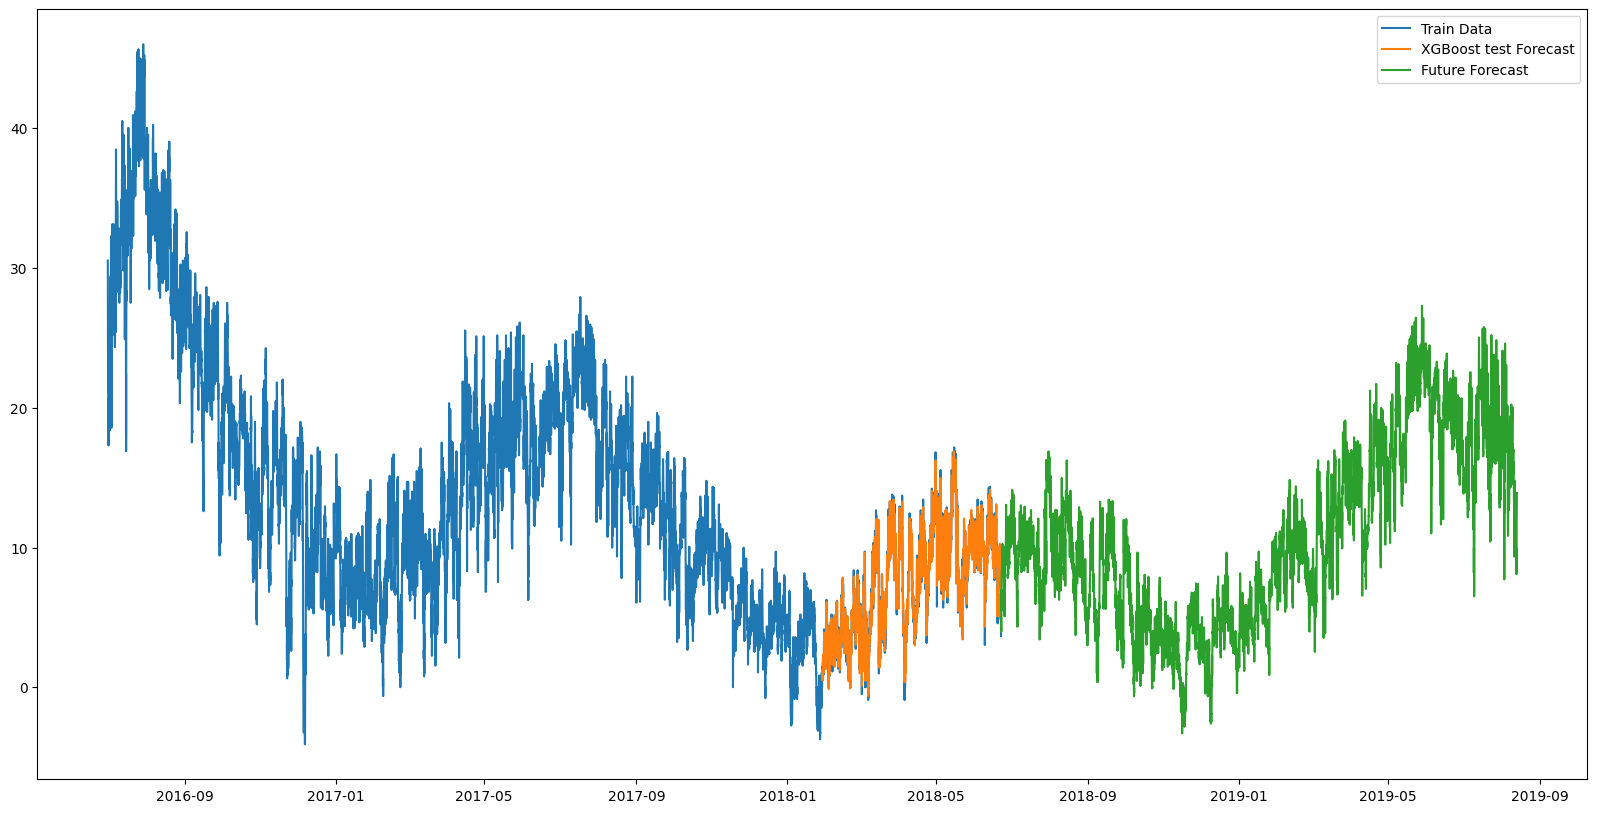

In [19]:
# Predict the next 100 values using the XGBoost model
forecast_future100 = model_xgb.predict(future_data.drop(['date'], axis=1))
# Plot original data and forecast
plt.figure(figsize=(20, 10))
plt.plot(df['date'], df['OT'], label='Train Data')
plt.plot(test_data['date'], forecast_test, label='XGBoost test Forecast')
plt.plot(future_data['date'], forecast_future100, label='Future Forecast')
plt.legend()
plt.show()

## Test evaluation

In [22]:
mae = mean_absolute_error(test_data['OT'], forecast_test)
print(f"Mean test Absolute Error: {mae:.5f}")

Mean test Absolute Error: 0.48842
